In [1]:
#Initial test of basic model with Breast Cancer Dataset
#Make sure that the InitialModel folder is within the same directory as the Data Folder with all the images
"""
Example:
+ Data
+ InitialModel
|--- initial_model_test.ipynb
"""
#Comment this to use GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [3]:
import os
#Global variables
DATA_PATH = os.path.join("..","Data")
RANDOM_SEED = 42
TEST_FRACTION = 0.2 # Just for initial test it must be something like 0.2
VALIDATION_FRACTION = 0.2 # Use the 20% of the non test samples to build the validation set (the remaining is the Test Set)
# Input patches are 50X50
IMAGE_WIDTH = 50 
IMAGE_LENGTH = 50

In [4]:
import numpy as np
np.random.seed(RANDOM_SEED)
import tensorflow as tf
tf.random.set_seed(RANDOM_SEED)
#RMSprop optimizer
from tensorflow.keras.optimizers import RMSprop 

import pandas as pd
from sklearn.model_selection import train_test_split
import glob

In [5]:
# read all patches
patches = []
for path in glob.glob(os.path.join(DATA_PATH,'**/*class*.png'), recursive = True):
    patches.append(path)

In [6]:
def createDataFrame():
    # Keep info within a Pandas dataframe
    data = pd.DataFrame({"path" : patches})
    # Obtain patient information by spliting the filename
    series_info = data["path"].str.split("idx").str[1].str.split("_")
    data['id'] = series_info.str[0] # this get the idx portion
    data['x'] = series_info.str[1].str[1:] # this get the x coord
    data['y'] = series_info.str[2].str[1:] # this get the y coord
    data['class'] = series_info.str[3] # this get the class
    data['class'] = data["class"].map({"class0.png" : "0" , "class1.png" : "1"}) #map to a number
    # Get the total number of registers from the class with the least number of samples 
    number_samples = min(data['class'].value_counts())    
    
    balanced_data = data[data['class'] == '0'].sample(n=number_samples, random_state=RANDOM_SEED, ignore_index=True)
    balanced_data = pd.concat([balanced_data, data[data['class'] == '1'].sample(n=number_samples, random_state=RANDOM_SEED, ignore_index=True)], ignore_index=True)
    
    balanced_data = balanced_data.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

    # sample the dataframe in such way that the data per class is balanced (same number of samples)
    return balanced_data

    
df = createDataFrame()
df

,path,id,x,y,class
0,..\Data\12748\0\12748_idx5_x401_y651_class0.png,5,401,651,0
1,..\Data\12751\1\12751_idx5_x2351_y1401_class1.png,5,2351,1401,1
2,..\Data\13694\1\13694_idx5_x1301_y1651_class1.png,5,1301,1651,1
3,..\Data\10272\0\10272_idx5_x2501_y1151_class0.png,5,2501,1151,0
4,..\Data\12949\1\12949_idx5_x1251_y1651_class1.png,5,1251,1651,1
...,...,...,...,...,...
157567,..\Data\8917\1\8917_idx5_x501_y851_class1.png,5,501,851,1
157568,..\Data\12951\1\12951_idx5_x1801_y1851_class1.png,5,1801,1851,1
157569,..\Data\10279\1\10279_idx5_x2301_y1401_class1.png,5,2301,1401,1
157570,..\Data\14304\1\14304_idx5_x801_y151_class1.png,5,801,151,1


In [7]:
# Split data into train and test sets
train_val, test = train_test_split(df, test_size=TEST_FRACTION, random_state=RANDOM_SEED, stratify=df['class'])
# Split train_val into train and validation
train, validation = train_test_split(train_val, test_size=VALIDATION_FRACTION, random_state=RANDOM_SEED, stratify=train_val['class'])


In [8]:
print("Train samples: ", len(train), "class 0:", len(train[train['class'] == '0']), "class 1:", len(train[train['class'] == '1']))
print("Validation samples: ", len(validation), "class 0:", len(validation[validation['class'] == '0']), "class 1:", len(validation[validation['class'] == '1']))
print("Test samples: ", len(test), "class 0:", len(test[test['class'] == '0']), "class 1:", len(test[test['class'] == '1']))

Train samples:  100845 class 0: 50422 class 1: 50423
Validation samples:  25212 class 0: 12606 class 1: 12606
Test samples:  31515 class 0: 15758 class 1: 15757


In [9]:
train.head()

,path,id,x,y,class
13813,..\Data\9078\0\9078_idx5_x1251_y1851_class0.png,5,1251,1851,0
148948,..\Data\15903\1\15903_idx5_x1351_y1351_class1.png,5,1351,1351,1
141717,..\Data\10273\1\10273_idx5_x2351_y2151_class1.png,5,2351,2151,1
49520,..\Data\16551\0\16551_idx5_x1801_y2451_class0.png,5,1801,2451,0
52377,..\Data\10273\1\10273_idx5_x2151_y851_class1.png,5,2151,851,1


In [10]:
test.head()

,path,id,x,y,class
73427,..\Data\14155\1\14155_idx5_x2901_y1501_class1.png,5,2901,1501,1
16475,..\Data\9029\0\9029_idx5_x401_y1401_class0.png,5,401,1401,0
154884,..\Data\9075\1\9075_idx5_x501_y551_class1.png,5,501,551,1
60639,..\Data\9323\0\9323_idx5_x451_y401_class0.png,5,451,401,0
134884,..\Data\15903\1\15903_idx5_x1851_y851_class1.png,5,1851,851,1


In [11]:
#load data from DataFrame see https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(rescale=1.0/255.0).flow_from_dataframe(dataframe = train, x_col = 'path', y_col='class', class_mode = 'binary',target_size=(50, 50), )
validation_generator = ImageDataGenerator(rescale=1.0/255.0).flow_from_dataframe(dataframe = validation, x_col = 'path', y_col='class', class_mode = 'binary',target_size=(50, 50),)
test_generator = ImageDataGenerator(rescale=1.0/255.0).flow_from_dataframe(dataframe = test, x_col = 'path', y_col='class', class_mode = 'binary',target_size=(50, 50),)


Found 100845 validated image filenames belonging to 2 classes.
Found 25212 validated image filenames belonging to 2 classes.
Found 31515 validated image filenames belonging to 2 classes.


In [12]:
# Inspect the first sample
X_1, y_1 = next(train_generator)
# Look shapes of the training samples and the labels
print("X_1 shape", X_1.shape)
print("y_1 shape", y_1.shape)

X_1 shape (32, 50, 50, 3)
y_1 shape (32,)


In [13]:
# Define a classical CNN architecture: conv -> max pool
def classical_model():
    # build and train a quite simple CNN binary classification model
    model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_LENGTH, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_LENGTH, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
        
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_LENGTH, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

    return model

model = classical_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

In [13]:
from keras.metrics import Precision, Recall

model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics= ['accuracy', Precision(), Recall()])

In [14]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [20]:
# Add callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

history = model.fit(train_generator,
    epochs=500,
    verbose=1,
    validation_data = validation_generator,
    callbacks=[es_callback]
)

Epoch 1/500
3152/3152 [==============================] - 869s 122ms/step - loss: 0.4954 - accuracy: 0.7693 - precision: 0.7763 - recall: 0.7567 - val_loss: 0.4375 - val_accuracy: 0.8130 - val_precision: 0.7894 - val_recall: 0.8539
Epoch 2/500
3152/3152 [==============================] - 61s 19ms/step - loss: 0.4454 - accuracy: 0.8136 - precision: 0.8215 - recall: 0.8013 - val_loss: 0.5708 - val_accuracy: 0.7920 - val_precision: 0.8936 - val_recall: 0.6629
Epoch 3/500
3152/3152 [==============================] - 58s 18ms/step - loss: 0.4242 - accuracy: 0.8241 - precision: 0.8281 - recall: 0.8179 - val_loss: 0.4989 - val_accuracy: 0.7563 - val_precision: 0.6850 - val_recall: 0.9488
Epoch 4/500
3152/3152 [==============================] - 58s 18ms/step - loss: 0.4157 - accuracy: 0.8263 - precision: 0.8274 - recall: 0.8246 - val_loss: 0.4262 - val_accuracy: 0.8276 - val_precision: 0.8385 - val_recall: 0.8115
Epoch 5/500
3152/3152 [==============================] - 59s 19ms/step - loss: 0.4

In [21]:
model.evaluate(validation_generator)

788/788 [==============================] - 19s 25ms/step - loss: 0.3685 - accuracy: 0.8465 - precision: 0.8402 - recall: 0.8557


[0.36849701404571533,
 0.8465016484260559,
 0.840239942073822,
 0.8557036519050598]

In [22]:
model.evaluate(test_generator)


985/985 [==============================] - 70s 71ms/step - loss: 0.3755 - accuracy: 0.8508 - precision: 0.8424 - recall: 0.8631


[0.3754580616950989,
 0.8508012294769287,
 0.8423660397529602,
 0.8631084561347961]

In [32]:
# Save the model
# model.save('classical_model.h5')

In [14]:
new_model = tf.keras.models.load_model('classical_model.h5')

In [15]:
new_model.evaluate(test_generator)

985/985 [==============================] - 105s 106ms/step - loss: 0.3755 - accuracy: 0.8508 - precision: 0.8424 - recall: 0.8631


[0.375467449426651, 0.8508012294769287, 0.8423660397529602, 0.8631084561347961]

# Prediction Stage

Once we have a trained model the following step is to use it to predict new samples

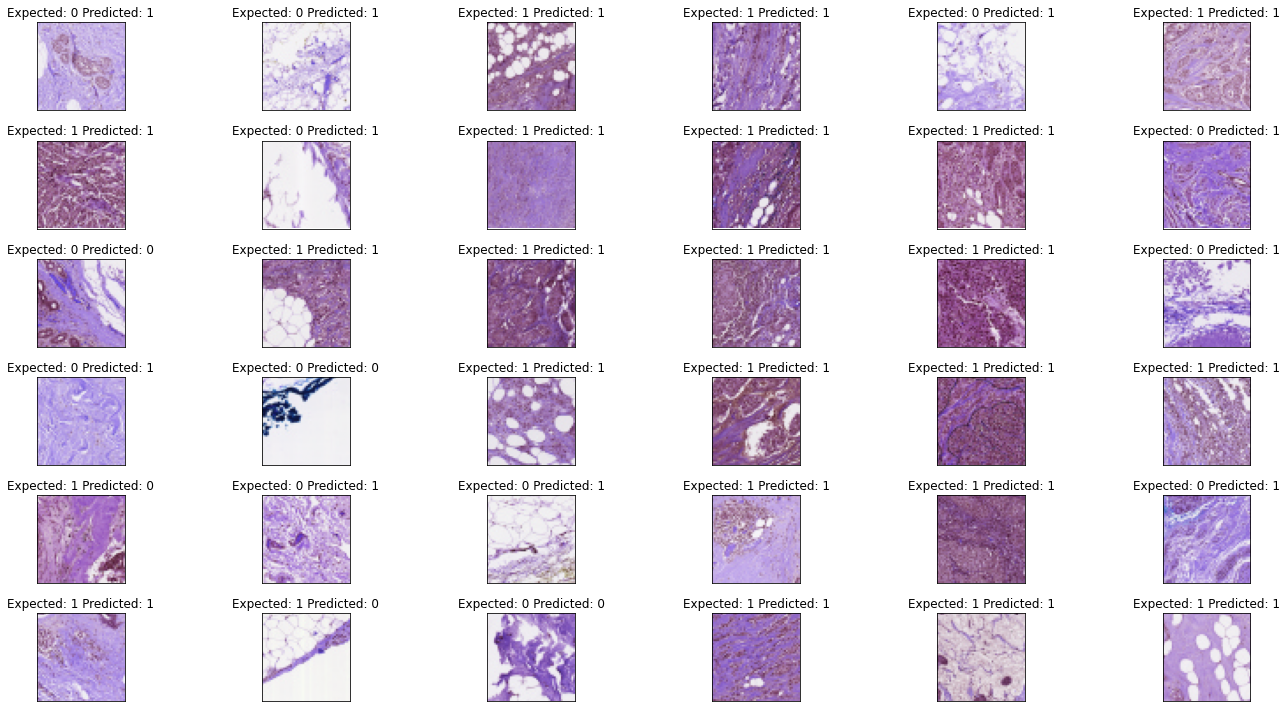

In [16]:
# Load a test image and visualize it
import cv2
import matplotlib.pyplot as plt
import math

def predict_random_samples(N):
    threshold = 0.5
    test_samples = test.sample(N)
    cols = math.floor(N ** 0.5)
    rows = math.ceil(N / cols) 
    fig, ax = plt.subplots(rows,cols,figsize=(20,10))

    counter = 0
    for index, test_sample in test_samples.iterrows():
        col = counter % cols
        row = counter // cols
        # Predicted the class of the image
        test_img = cv2.imread(test_sample['path']) / 255.0 

        y_pred = new_model.predict(test_img.reshape((1,50,50,3)), verbose = 0)
        predicted_class = np.where(y_pred > threshold, 1,0)[0][0]
        ax[row,col].imshow(test_img)
        ax[row,col].set_title(f'Expected: {test_sample["class"]} Predicted: {predicted_class}')
        ax[row,col].get_xaxis().set_visible(False)
        ax[row,col].get_yaxis().set_visible(False)

        counter += 1
    fig.tight_layout()
    plt.show()

predict_random_samples(36)




# Prediction over a larger image

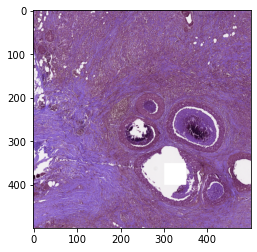

In [17]:
# Load a large image
large_image_path = os.path.join("..","PreprocessedData", "Tiles(500, 500)", "8863", "12.png")
large_image = cv2.imread(large_image_path) / 255.0 
plt.imshow(large_image)

(-0.5, 49.5, 49.5, -0.5)

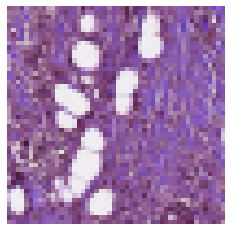

In [18]:
# Classify the upper left corner
ul = large_image[:50,:50,:]

y_pred = new_model.predict(ul.reshape((1,50,50,3)), verbose = 0)
predicted_class = np.where(y_pred > 0.5, 1,0)[0][0]
plt.imshow(ul)
plt.axis('off')

# As the patch has cancer add a red mask over it

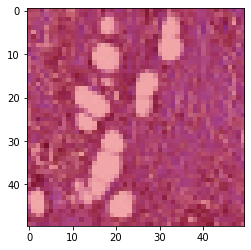

In [19]:
#https://stackoverflow.com/questions/46020894/superimpose-heatmap-on-a-base-image-opencv-python
mask = np.zeros((50,50,3)) 
mask[:,:,0] = 1.0 * y_pred[0][0]

super_imposed_img = cv2.addWeighted(mask, 0.3, ul, 0.7, 0)

plt.imshow(super_imposed_img)


0.96468747


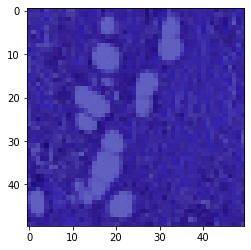

In [47]:
mask = np.zeros((50,50,3)) 
mask[:,:,:] = 1 - 1.0 * y_pred[0][0]
print(y_pred[0][0])
mask = mask * 255
mask = mask.astype(np.uint8)

heatmap_img = cv2.applyColorMap(mask * 255, cv2.COLORMAP_JET)
plt.imshow(heatmap_img)

super_imposed_img = cv2.addWeighted(heatmap_img, 0.6, (ul*255).astype(np.uint8), 0.4, 0)

plt.imshow(super_imposed_img)



In [ ]:
#use colormap

#https://stackoverflow.com/questions/46020894/superimpose-heatmap-on-a-base-image-opencv-python
mask = np.zeros((50,50,3)) 
mask[:,:,0] = 1.0 * y_pred[0][0]

super_imposed_img = cv2.addWeighted(mask, 0.3, ul, 0.7, 0)

plt.imshow(super_imposed_img)


In [28]:
#see https://stackoverflow.com/questions/46020894/superimpose-heatmap-on-a-base-image-opencv-python
#given a large image tint with a red color the zones with cancer 
def tint_image(path):
    input_image = cv2.imread(path) / 255.0 
    PW = 50
    PH = 50
    mask = np.zeros(input_image.shape)
    for col in range(0,input_image.shape[0],PW):
        for row in range(0,input_image.shape[1],PH):
            patch = input_image[row:row+PH, col:col+PW, :]
            y_pred = new_model.predict(patch.reshape((1,50,50,3)), verbose = 0)
            mask[row:row+PH, col:col+PW, 0] =  1 * y_pred[0][0]
            mask[row:row+PH, col:col+PW, 0] =  1 * y_pred[0][0]
            
    return cv2.addWeighted(mask, 0.3, input_image, 0.7, 0)

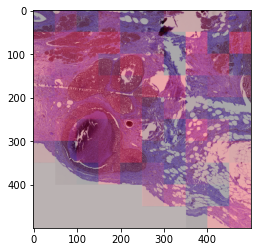

In [29]:
plt.imshow(tint_image(os.path.join("..","PreprocessedData", "Tiles(500, 500)", "8863", "16.png")))